# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [1]:
import random
import matplotlib.pyplot as plt
import time

In [2]:
# Problem Constants
NUM_PEOPLE = 4
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [3]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 1500           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [4]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    print(subheader)
    print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(fitness_history, avg_fitness_history):
    """
    Plots the best and average fitness score per generation.

    Args:
        fitness_history (list): A list of fitness scores for each generation
        avg_fitness_history (list): A list of average fitness scores for each generation.
    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(fitness_history) + 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-', label='Best Fitness')
    plt.plot(generations, avg_fitness_history, marker='x', linestyle='--', label='Average Fitness')

    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    # Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
    min_fitness = min(min(fitness_history), min(avg_fitness_history))
    plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
    plt.legend()
    plt.grid(True)
    plt.show()

## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [5]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [6]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties

    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [7]:
def parent_selection(population, fitness_scores):
    paired = list(zip(population, fitness_scores))
    paired.sort(key = lambda x: x[1])

    selected_parents = [individual for individual, _ in paired[:10]]
    return selected_parents

## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [8]:
def crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    offspring = []
    for i in range(num_people):
        child = []
        for j in range(shifts_per_week):
            if random.random() < crossover_rate:
                child.append(parent_2[i][j])
            else: 
                child.append(parent_2[i][j])
        offspring.append(child)
    return offspring

## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [9]:
def mutate(schedule, mutation_rate, num_people, shifts_per_week):
    """
    Applies random mutations to the schedule.
    Each bit has a mutation_rate probability of being flipped.

    Args:
        schedule (list): The schedule to mutate.
        mutation_rate (float): Probability of flipping each bit.
        num_people (int): Number of people in the schedule.
        shifts_per_week (int): Number of shifts per week.

    Returns:
        mutated_schedule (list): A new mutated version of the schedule.
    """
    mutated_schedule = []
    for p in range(num_people):
        person_schedule = []
        for s in range(shifts_per_week):
            if random.random() < mutation_rate:
                # Flip bit: 0 -> 1, 1 -> 0
                person_schedule.append(1 - schedule[p][s])
            else:
                person_schedule.append(schedule[p][s])
        mutated_schedule.append(person_schedule)
    return mutated_schedule

## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [10]:
def select_survivors(population, offspring_population, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week):
    """
    Selects the next generation by combining parents and offspring and picking the best individuals.

    Args:
        population (list): Current generation.
        offspring_population (list): Newly generated offspring.
        population_size (int): Number of individuals to keep.
        num_people (int): Number of people.
        shifts_per_week (int): Number of shifts per week.
        shifts_per_day (int): Number of shifts per day.
        days_per_week (int): Number of days per week.

    Returns:
        new_population (list): Selected individuals for the next generation.
    """
    combined = population + offspring_population
    fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in combined]

    # Sort by fitness (higher is better)
    paired = list(zip(combined, fitness_scores))
    paired.sort(key=lambda x: x[1], reverse=True)

    # Pick top individuals
    selected = [individual for individual, _ in paired[:population_size]]
    return selected

## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [11]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Runs the genetic algorithm for ATC scheduling.

    Args:
        population_size (int): Number of individuals in each generation.
        num_people (int): Number of controllers.
        shifts_per_week (int): Number of shifts in the week.
        shifts_per_day (int): Number of shifts in a day.
        days_per_week (int): Number of days per week.
        generations (int): Number of generations.
        mutation_rate (float): Mutation rate for each bit.
        crossover_rate (float): Crossover rate between parents.

    Returns:
        best_schedule (list): The best schedule found.
        best_fitness (float): The fitness of the best schedule.
        fitness_history (list): Best fitness value per generation.
        avg_history (list): avg fitness value per generation.
    """
    population = generate_population(population_size, num_people, shifts_per_week)
    fitness_history = []
    avg_history = [] 

    for gen in range(generations):
        # Evaluate fitness
        fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]


        # Parent selection
        selected_parents = parent_selection(population, fitness_scores)

        # Generate offspring
        offspring = []
        while len(offspring) < population_size:
            parent1 = random.choice(selected_parents)
            parent2 = random.choice(selected_parents)
            child = crossover(parent1, parent2, num_people, shifts_per_week, crossover_rate)
            mutated_child = mutate(child, mutation_rate, num_people, shifts_per_week)
            offspring.append(mutated_child)

        # Survivor selection
        population = select_survivors(population, offspring, population_size, num_people, shifts_per_week, shifts_per_day, days_per_week)

        # Track best fitness
        current_fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
        best_fitness = max(current_fitness_scores)
        avg_fitness_in_gen = sum(current_fitness_scores) / len(current_fitness_scores)

        fitness_history.append(best_fitness)
        avg_history.append(avg_fitness_in_gen)

        if (gen+1) % 10 == 0 or gen == 0:
            print(f"Generation {gen+1}: Best Fitness = {best_fitness:.2f}")

    # After all generations
    final_fitness_scores = [evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day) for schedule in population]
    best_index = final_fitness_scores.index(max(final_fitness_scores))
    best_schedule = population[best_index]
    best_fitness = final_fitness_scores[best_index]
    
    return best_schedule, best_fitness, fitness_history, avg_history

# Main

Run the genetic algorithm and plot the fitness scores.

Generation 1: Best Fitness = -45.00
Generation 10: Best Fitness = -45.00
Generation 20: Best Fitness = -45.00
Generation 30: Best Fitness = -38.00
Generation 40: Best Fitness = -33.00
Generation 50: Best Fitness = -33.00
Generation 60: Best Fitness = -29.00
Generation 70: Best Fitness = -27.00
Generation 80: Best Fitness = -25.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -21.00
Generation 110: Best Fitness = -20.00
Generation 120: Best Fitness = -19.00
Generation 130: Best Fitness = -17.00
Generation 140: Best Fitness = -17.00
Generation 150: Best Fitness = -17.00
Generation 160: Best Fitness = -15.00
Generation 170: Best Fitness = -14.00
Generation 180: Best Fitness = -14.00
Generation 190: Best Fitness = -14.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -12.00
Generation 230: Best Fitness = -12.00
Generation 240: Best Fitness = -12.00
Generation 250: Best Fitness = -11.00
Generation 260: Best Fi

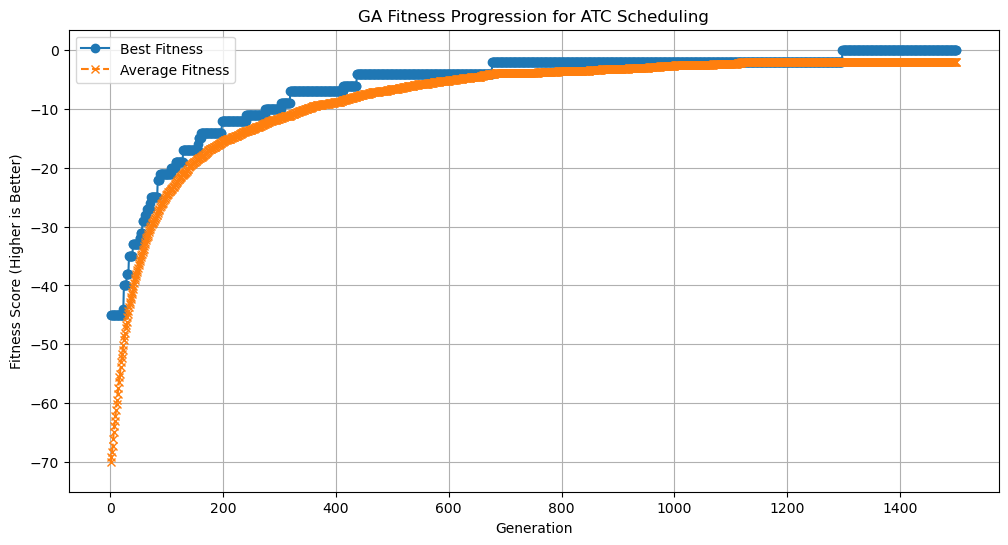

In [13]:
best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size = POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history, avg_history)

# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

4 air traffice controllers are needed at minimum.

b. Describe how you came up with your answer to part A and how confident you are in that answer. 

I professively reduced the number of controllers, and verified using the genetic algorithm whether a valid schedule could still be found. 
I'm reasonably confident in my answer because the genetic algorithm was run over a large number of generations, and multiple times when solutions became hard to find. However, due to the probabilistic nature of genetic algorithms, there is still a small change that a more optimized solution is possible.

# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.

Generation 1: Best Fitness = -43.00
Generation 10: Best Fitness = -43.00
Generation 20: Best Fitness = -43.00
Generation 30: Best Fitness = -43.00
Generation 40: Best Fitness = -36.00
Generation 50: Best Fitness = -32.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -24.00
Generation 80: Best Fitness = -23.00
Generation 90: Best Fitness = -20.00
Generation 100: Best Fitness = -19.00
Generation 110: Best Fitness = -16.00
Generation 120: Best Fitness = -16.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -12.00
Generation 150: Best Fitness = -12.00
Generation 160: Best Fitness = -12.00
Generation 170: Best Fitness = -12.00
Generation 180: Best Fitness = -12.00
Generation 190: Best Fitness = -11.00
Generation 200: Best Fitness = -11.00
Generation 210: Best Fitness = -10.00
Generation 220: Best Fitness = -10.00
Generation 230: Best Fitness = -10.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

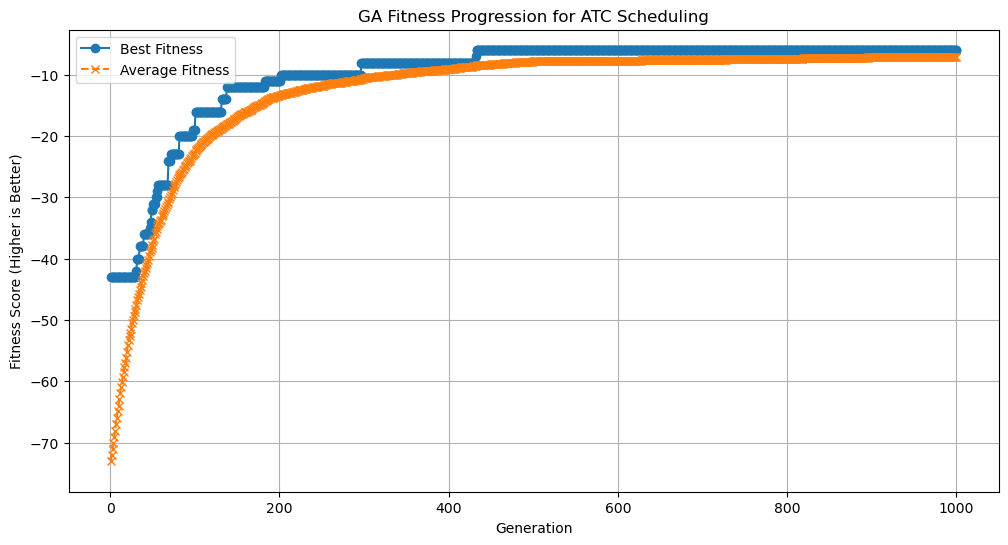

Generation 1: Best Fitness = -52.00
Generation 10: Best Fitness = -52.00
Generation 20: Best Fitness = -47.00
Generation 30: Best Fitness = -42.00
Generation 40: Best Fitness = -38.00
Generation 50: Best Fitness = -33.00
Generation 60: Best Fitness = -29.00
Generation 70: Best Fitness = -25.00
Generation 80: Best Fitness = -21.00
Generation 90: Best Fitness = -20.00
Generation 100: Best Fitness = -19.00
Generation 110: Best Fitness = -17.00
Generation 120: Best Fitness = -17.00
Generation 130: Best Fitness = -13.00
Generation 140: Best Fitness = -13.00
Generation 150: Best Fitness = -13.00
Generation 160: Best Fitness = -11.00
Generation 170: Best Fitness = -11.00
Generation 180: Best Fitness = -10.00
Generation 190: Best Fitness = -10.00
Generation 200: Best Fitness = -9.00
Generation 210: Best Fitness = -9.00
Generation 220: Best Fitness = -9.00
Generation 230: Best Fitness = -9.00
Generation 240: Best Fitness = -8.00
Generation 250: Best Fitness = -8.00
Generation 260: Best Fitness 

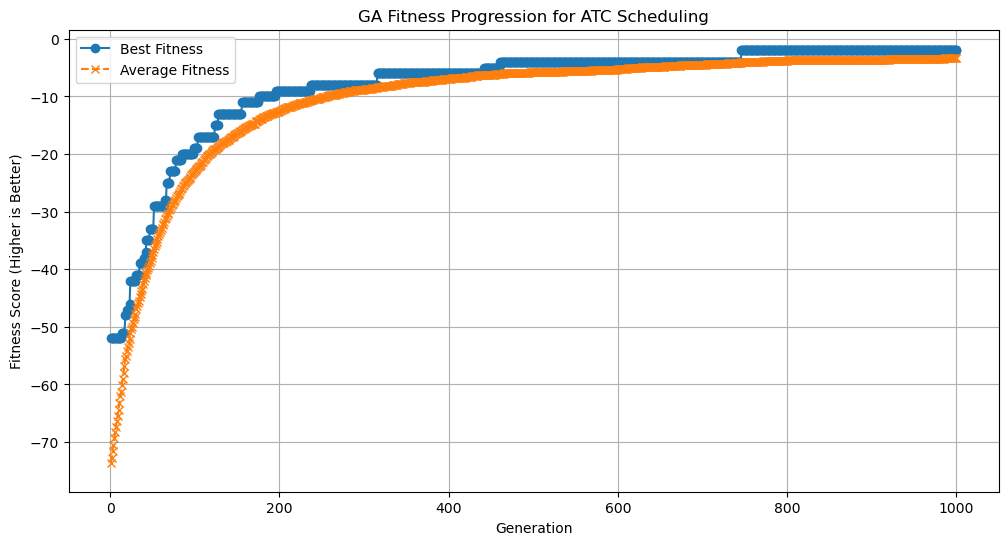

Generation 1: Best Fitness = -48.00
Generation 10: Best Fitness = -48.00
Generation 20: Best Fitness = -48.00
Generation 30: Best Fitness = -41.00
Generation 40: Best Fitness = -39.00
Generation 50: Best Fitness = -31.00
Generation 60: Best Fitness = -27.00
Generation 70: Best Fitness = -27.00
Generation 80: Best Fitness = -24.00
Generation 90: Best Fitness = -23.00
Generation 100: Best Fitness = -21.00
Generation 110: Best Fitness = -19.00
Generation 120: Best Fitness = -19.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -16.00
Generation 150: Best Fitness = -15.00
Generation 160: Best Fitness = -14.00
Generation 170: Best Fitness = -14.00
Generation 180: Best Fitness = -14.00
Generation 190: Best Fitness = -12.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -12.00
Generation 230: Best Fitness = -11.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -9.00
Generation 260: Best Fit

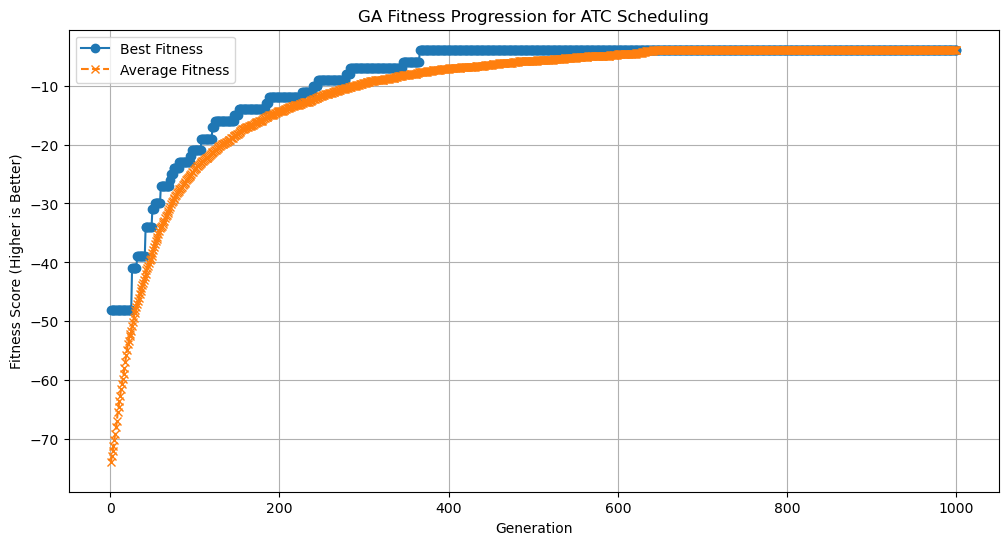

Generation 1: Best Fitness = -42.00
Generation 10: Best Fitness = -42.00
Generation 20: Best Fitness = -42.00
Generation 30: Best Fitness = -42.00
Generation 40: Best Fitness = -37.00
Generation 50: Best Fitness = -33.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -27.00
Generation 80: Best Fitness = -24.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -20.00
Generation 110: Best Fitness = -20.00
Generation 120: Best Fitness = -20.00
Generation 130: Best Fitness = -18.00
Generation 140: Best Fitness = -17.00
Generation 150: Best Fitness = -14.00
Generation 160: Best Fitness = -14.00
Generation 170: Best Fitness = -14.00
Generation 180: Best Fitness = -13.00
Generation 190: Best Fitness = -13.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -12.00
Generation 230: Best Fitness = -11.00
Generation 240: Best Fitness = -11.00
Generation 250: Best Fitness = -11.00
Generation 260: Best Fi

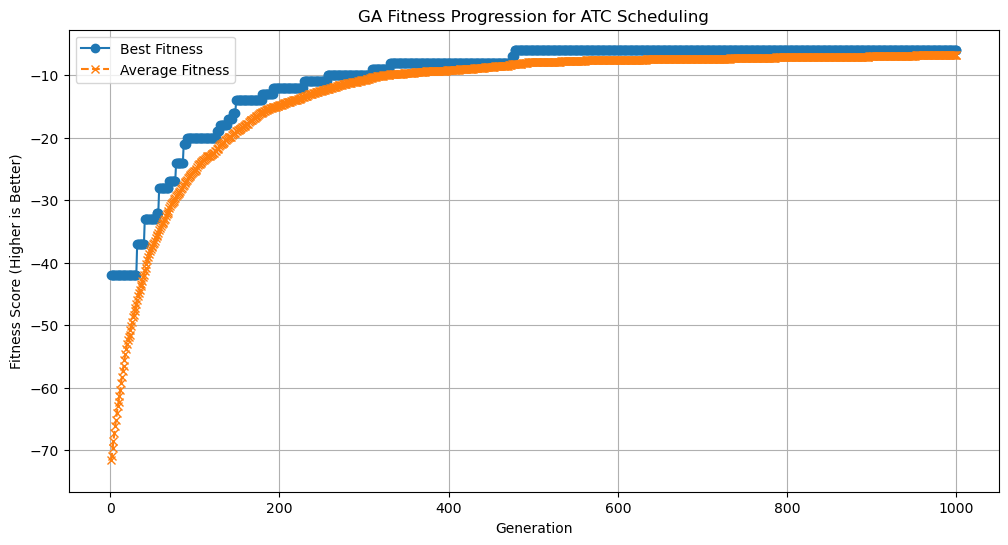

Generation 1: Best Fitness = -43.00
Generation 10: Best Fitness = -43.00
Generation 20: Best Fitness = -43.00
Generation 30: Best Fitness = -40.00
Generation 40: Best Fitness = -35.00
Generation 50: Best Fitness = -28.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -25.00
Generation 80: Best Fitness = -22.00
Generation 90: Best Fitness = -22.00
Generation 100: Best Fitness = -18.00
Generation 110: Best Fitness = -18.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -17.00
Generation 140: Best Fitness = -17.00
Generation 150: Best Fitness = -15.00
Generation 160: Best Fitness = -13.00
Generation 170: Best Fitness = -13.00
Generation 180: Best Fitness = -12.00
Generation 190: Best Fitness = -12.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -10.00
Generation 220: Best Fitness = -10.00
Generation 230: Best Fitness = -10.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -9.00
Generation 260: Best Fit

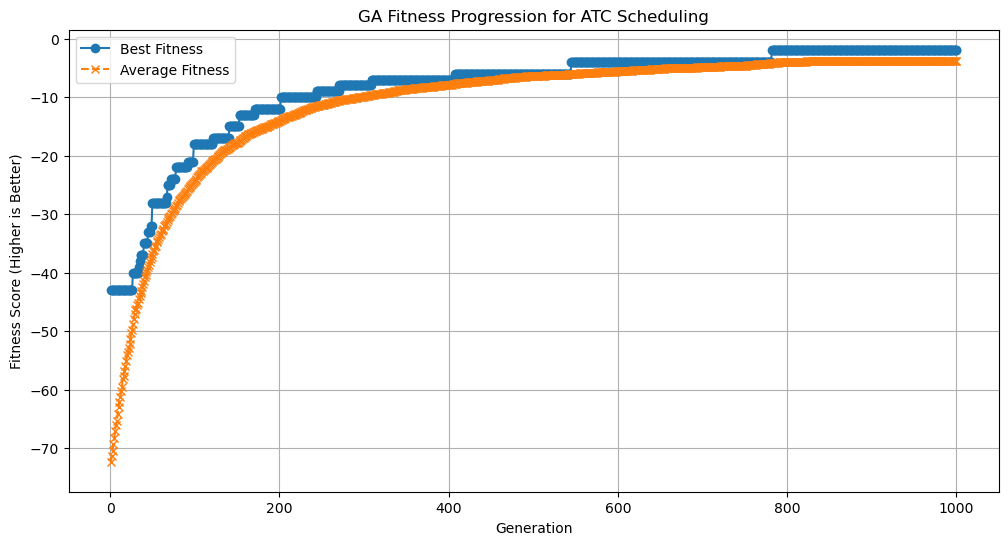

Generation 1: Best Fitness = -45.00
Generation 10: Best Fitness = -45.00
Generation 20: Best Fitness = -43.00
Generation 30: Best Fitness = -41.00
Generation 40: Best Fitness = -38.00
Generation 50: Best Fitness = -34.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -27.00
Generation 80: Best Fitness = -23.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -19.00
Generation 110: Best Fitness = -19.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -16.00
Generation 150: Best Fitness = -15.00
Generation 160: Best Fitness = -15.00
Generation 170: Best Fitness = -13.00
Generation 180: Best Fitness = -13.00
Generation 190: Best Fitness = -11.00
Generation 200: Best Fitness = -11.00
Generation 210: Best Fitness = -11.00
Generation 220: Best Fitness = -11.00
Generation 230: Best Fitness = -11.00
Generation 240: Best Fitness = -11.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

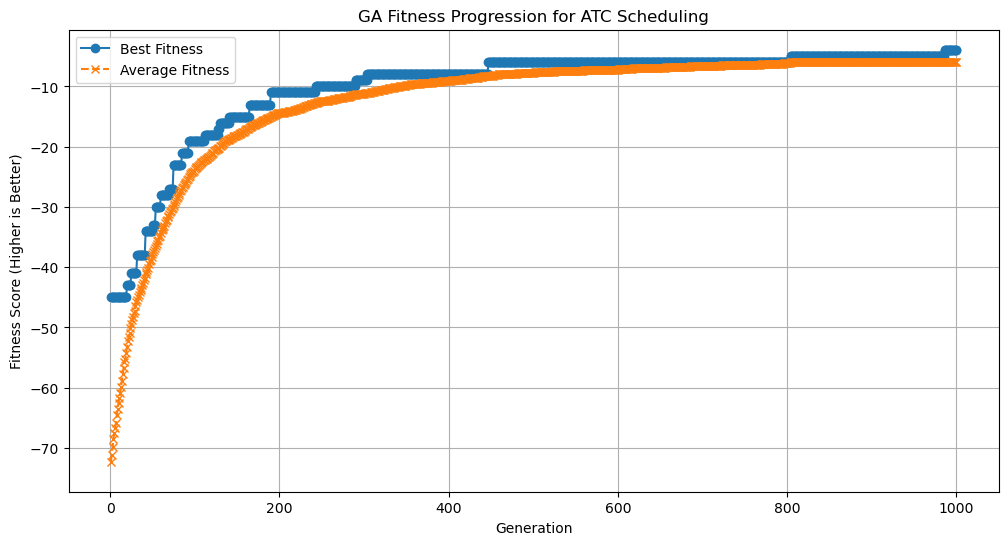

Generation 1: Best Fitness = -40.00
Generation 10: Best Fitness = -40.00
Generation 20: Best Fitness = -40.00
Generation 30: Best Fitness = -39.00
Generation 40: Best Fitness = -34.00
Generation 50: Best Fitness = -32.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -26.00
Generation 80: Best Fitness = -23.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -20.00
Generation 110: Best Fitness = -18.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -15.00
Generation 140: Best Fitness = -15.00
Generation 150: Best Fitness = -12.00
Generation 160: Best Fitness = -12.00
Generation 170: Best Fitness = -12.00
Generation 180: Best Fitness = -11.00
Generation 190: Best Fitness = -10.00
Generation 200: Best Fitness = -9.00
Generation 210: Best Fitness = -9.00
Generation 220: Best Fitness = -9.00
Generation 230: Best Fitness = -8.00
Generation 240: Best Fitness = -8.00
Generation 250: Best Fitness = -8.00
Generation 260: Best Fitness 

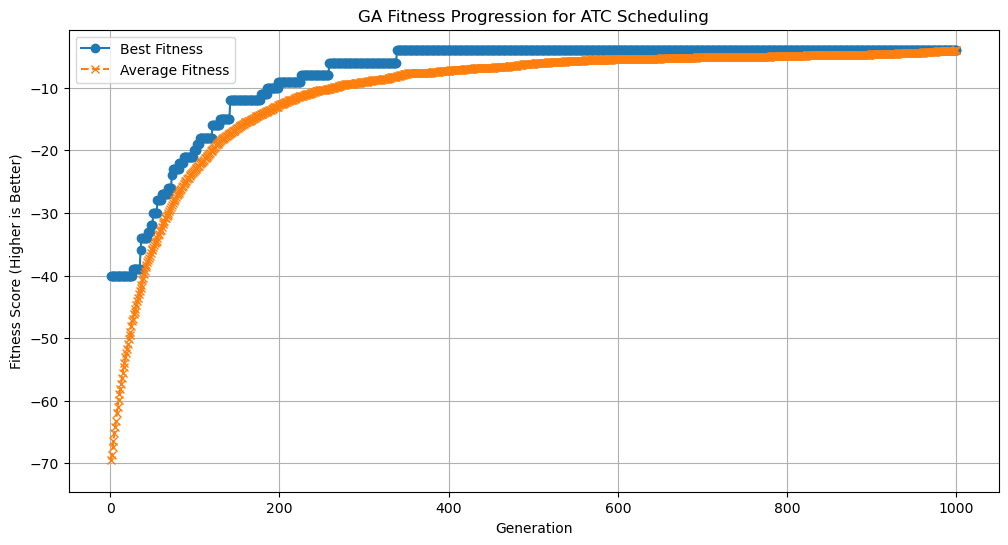

Generation 1: Best Fitness = -40.00
Generation 10: Best Fitness = -40.00
Generation 20: Best Fitness = -40.00
Generation 30: Best Fitness = -40.00
Generation 40: Best Fitness = -37.00
Generation 50: Best Fitness = -29.00
Generation 60: Best Fitness = -29.00
Generation 70: Best Fitness = -27.00
Generation 80: Best Fitness = -22.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -21.00
Generation 110: Best Fitness = -18.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -16.00
Generation 150: Best Fitness = -15.00
Generation 160: Best Fitness = -15.00
Generation 170: Best Fitness = -15.00
Generation 180: Best Fitness = -15.00
Generation 190: Best Fitness = -14.00
Generation 200: Best Fitness = -11.00
Generation 210: Best Fitness = -11.00
Generation 220: Best Fitness = -11.00
Generation 230: Best Fitness = -11.00
Generation 240: Best Fitness = -11.00
Generation 250: Best Fitness = -11.00
Generation 260: Best Fi

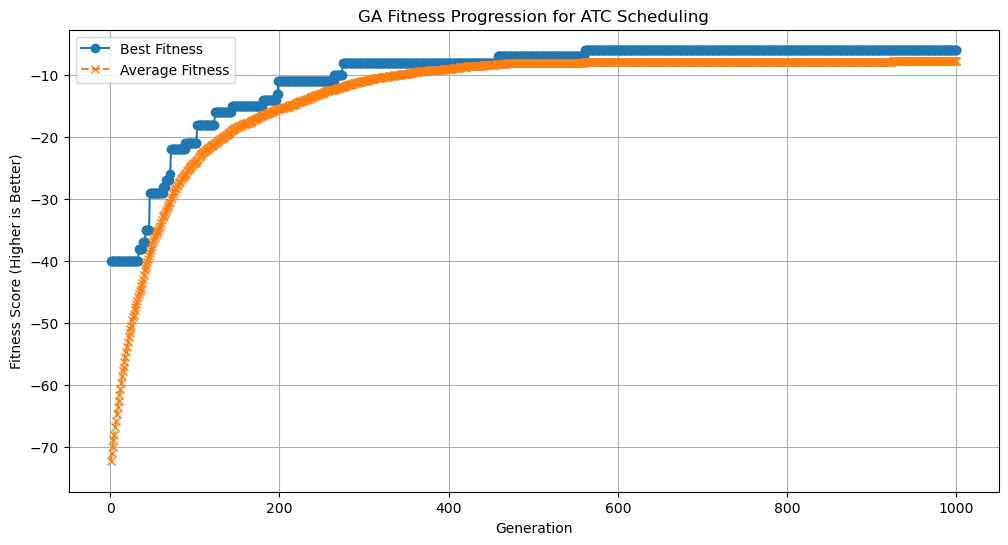

Generation 1: Best Fitness = -40.00
Generation 10: Best Fitness = -40.00
Generation 20: Best Fitness = -40.00
Generation 30: Best Fitness = -40.00
Generation 40: Best Fitness = -33.00
Generation 50: Best Fitness = -30.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -25.00
Generation 80: Best Fitness = -24.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -20.00
Generation 110: Best Fitness = -20.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -15.00
Generation 140: Best Fitness = -15.00
Generation 150: Best Fitness = -15.00
Generation 160: Best Fitness = -13.00
Generation 170: Best Fitness = -13.00
Generation 180: Best Fitness = -13.00
Generation 190: Best Fitness = -11.00
Generation 200: Best Fitness = -10.00
Generation 210: Best Fitness = -10.00
Generation 220: Best Fitness = -10.00
Generation 230: Best Fitness = -10.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -8.00
Generation 260: Best Fit

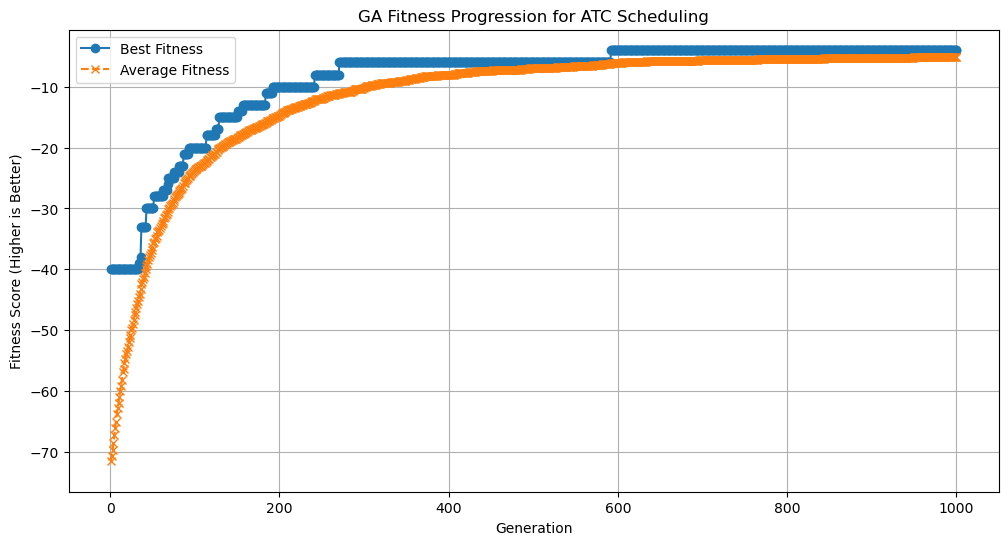

Generation 1: Best Fitness = -44.00
Generation 10: Best Fitness = -44.00
Generation 20: Best Fitness = -44.00
Generation 30: Best Fitness = -36.00
Generation 40: Best Fitness = -36.00
Generation 50: Best Fitness = -32.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -26.00
Generation 80: Best Fitness = -20.00
Generation 90: Best Fitness = -20.00
Generation 100: Best Fitness = -20.00
Generation 110: Best Fitness = -16.00
Generation 120: Best Fitness = -16.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -14.00
Generation 150: Best Fitness = -14.00
Generation 160: Best Fitness = -14.00
Generation 170: Best Fitness = -10.00
Generation 180: Best Fitness = -10.00
Generation 190: Best Fitness = -10.00
Generation 200: Best Fitness = -10.00
Generation 210: Best Fitness = -10.00
Generation 220: Best Fitness = -10.00
Generation 230: Best Fitness = -10.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

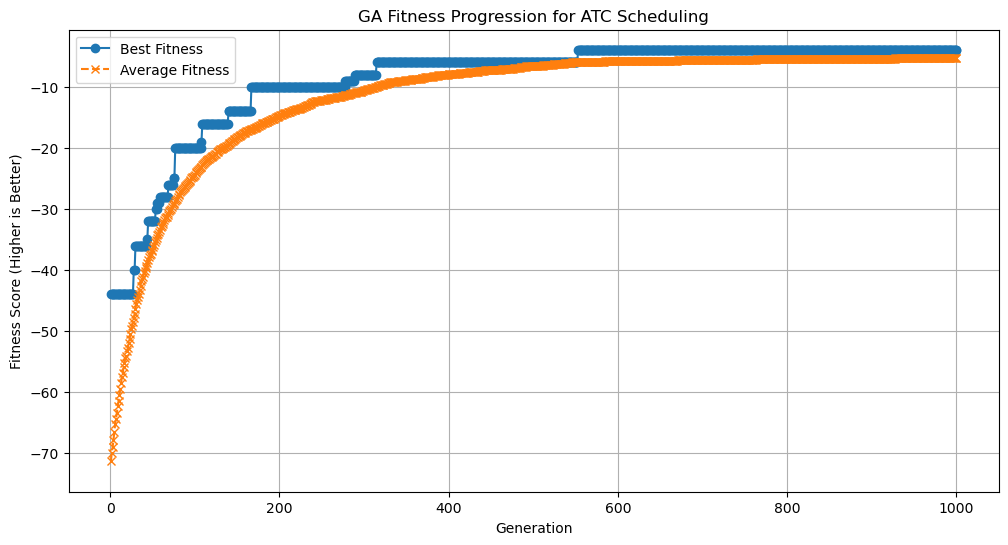

Generation 1: Best Fitness = -46.00
Generation 10: Best Fitness = -46.00
Generation 20: Best Fitness = -46.00
Generation 30: Best Fitness = -39.00
Generation 40: Best Fitness = -37.00
Generation 50: Best Fitness = -33.00
Generation 60: Best Fitness = -30.00
Generation 70: Best Fitness = -26.00
Generation 80: Best Fitness = -25.00
Generation 90: Best Fitness = -20.00
Generation 100: Best Fitness = -19.00
Generation 110: Best Fitness = -17.00
Generation 120: Best Fitness = -17.00
Generation 130: Best Fitness = -17.00
Generation 140: Best Fitness = -17.00
Generation 150: Best Fitness = -14.00
Generation 160: Best Fitness = -14.00
Generation 170: Best Fitness = -13.00
Generation 180: Best Fitness = -12.00
Generation 190: Best Fitness = -12.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -12.00
Generation 230: Best Fitness = -12.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

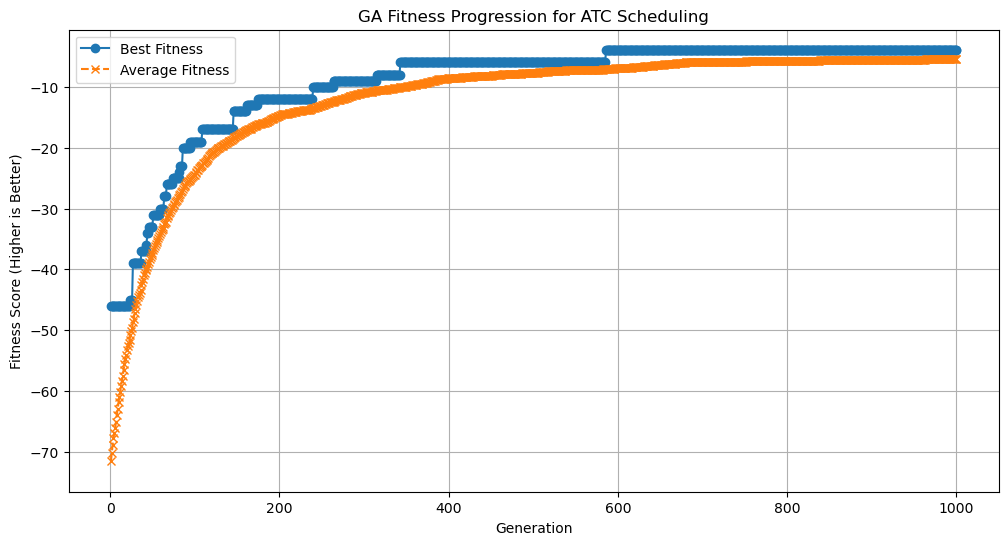

Generation 1: Best Fitness = -45.00
Generation 10: Best Fitness = -45.00
Generation 20: Best Fitness = -44.00
Generation 30: Best Fitness = -40.00
Generation 40: Best Fitness = -34.00
Generation 50: Best Fitness = -31.00
Generation 60: Best Fitness = -28.00
Generation 70: Best Fitness = -25.00
Generation 80: Best Fitness = -24.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -16.00
Generation 110: Best Fitness = -16.00
Generation 120: Best Fitness = -16.00
Generation 130: Best Fitness = -15.00
Generation 140: Best Fitness = -14.00
Generation 150: Best Fitness = -14.00
Generation 160: Best Fitness = -14.00
Generation 170: Best Fitness = -13.00
Generation 180: Best Fitness = -12.00
Generation 190: Best Fitness = -12.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -10.00
Generation 220: Best Fitness = -9.00
Generation 230: Best Fitness = -9.00
Generation 240: Best Fitness = -8.00
Generation 250: Best Fitness = -8.00
Generation 260: Best Fitnes

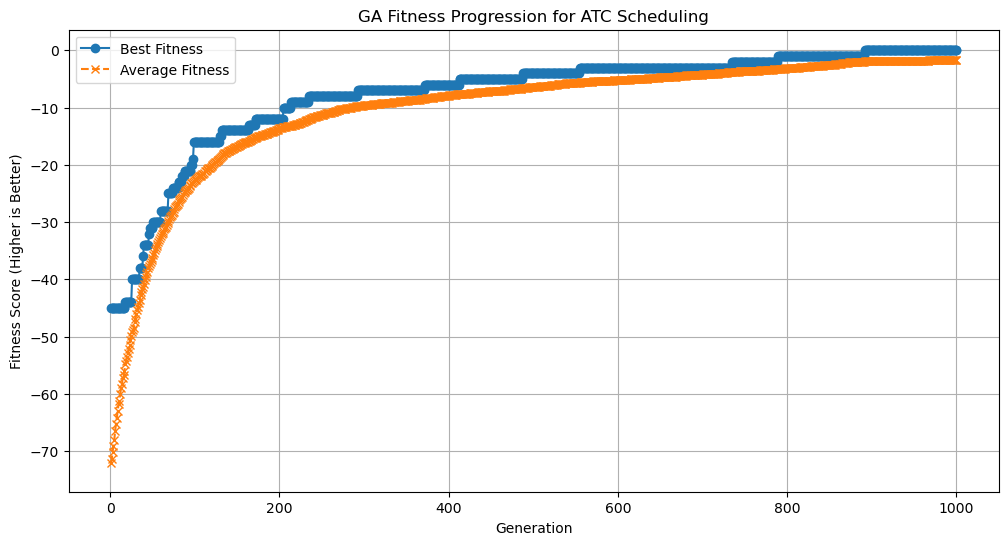

Generation 1: Best Fitness = -49.00
Generation 10: Best Fitness = -49.00
Generation 20: Best Fitness = -47.00
Generation 30: Best Fitness = -38.00
Generation 40: Best Fitness = -34.00
Generation 50: Best Fitness = -32.00
Generation 60: Best Fitness = -29.00
Generation 70: Best Fitness = -25.00
Generation 80: Best Fitness = -25.00
Generation 90: Best Fitness = -23.00
Generation 100: Best Fitness = -19.00
Generation 110: Best Fitness = -19.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -17.00
Generation 140: Best Fitness = -16.00
Generation 150: Best Fitness = -16.00
Generation 160: Best Fitness = -12.00
Generation 170: Best Fitness = -12.00
Generation 180: Best Fitness = -12.00
Generation 190: Best Fitness = -12.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -11.00
Generation 230: Best Fitness = -10.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

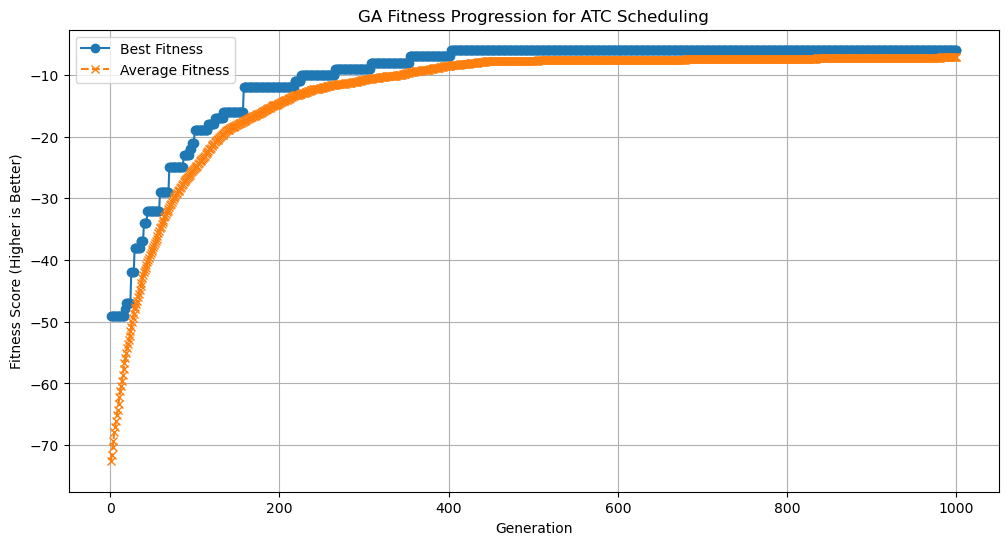

Generation 1: Best Fitness = -40.00
Generation 10: Best Fitness = -40.00
Generation 20: Best Fitness = -40.00
Generation 30: Best Fitness = -40.00
Generation 40: Best Fitness = -34.00
Generation 50: Best Fitness = -32.00
Generation 60: Best Fitness = -27.00
Generation 70: Best Fitness = -27.00
Generation 80: Best Fitness = -24.00
Generation 90: Best Fitness = -23.00
Generation 100: Best Fitness = -21.00
Generation 110: Best Fitness = -19.00
Generation 120: Best Fitness = -18.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -16.00
Generation 150: Best Fitness = -12.00
Generation 160: Best Fitness = -12.00
Generation 170: Best Fitness = -12.00
Generation 180: Best Fitness = -12.00
Generation 190: Best Fitness = -12.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -10.00
Generation 230: Best Fitness = -10.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

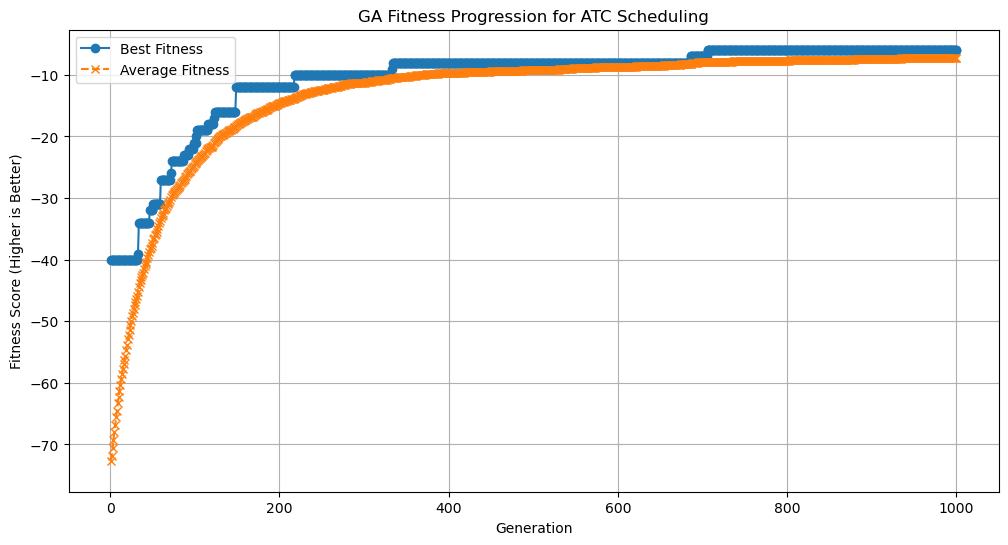

Generation 1: Best Fitness = -47.00
Generation 10: Best Fitness = -47.00
Generation 20: Best Fitness = -47.00
Generation 30: Best Fitness = -41.00
Generation 40: Best Fitness = -37.00
Generation 50: Best Fitness = -32.00
Generation 60: Best Fitness = -30.00
Generation 70: Best Fitness = -24.00
Generation 80: Best Fitness = -24.00
Generation 90: Best Fitness = -21.00
Generation 100: Best Fitness = -21.00
Generation 110: Best Fitness = -19.00
Generation 120: Best Fitness = -16.00
Generation 130: Best Fitness = -16.00
Generation 140: Best Fitness = -15.00
Generation 150: Best Fitness = -15.00
Generation 160: Best Fitness = -15.00
Generation 170: Best Fitness = -13.00
Generation 180: Best Fitness = -13.00
Generation 190: Best Fitness = -13.00
Generation 200: Best Fitness = -12.00
Generation 210: Best Fitness = -12.00
Generation 220: Best Fitness = -11.00
Generation 230: Best Fitness = -11.00
Generation 240: Best Fitness = -10.00
Generation 250: Best Fitness = -10.00
Generation 260: Best Fi

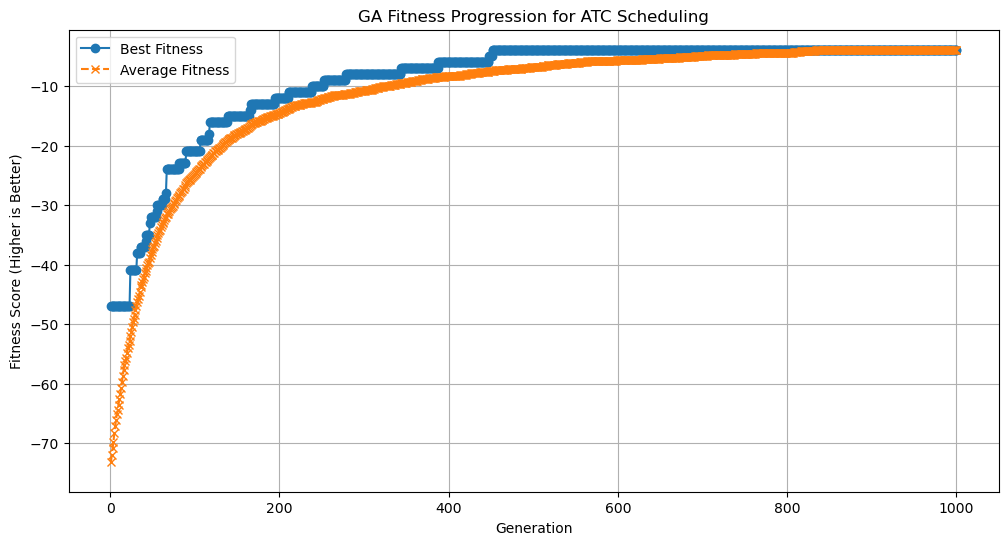

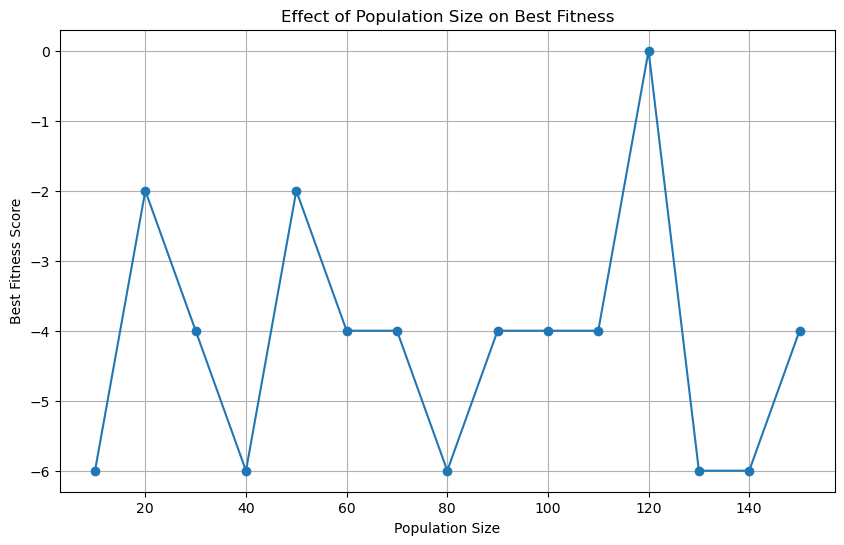

In [182]:
GENERATIONS = 1000
NUM_PEOPLE = 4
population_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]  # values you want to sweep
best_fitness_scores = []
for pop in population_sizes:
    best_schedule, best_fitness, history, avg_history = genetic_algorithm(
            population_size=POPULATION_SIZE, # parameter you could pick to sweep 
            num_people=NUM_PEOPLE,
            shifts_per_week=SHIFTS_PER_WEEK,
            shifts_per_day=SHIFTS_PER_DAY,
            days_per_week=DAYS_PER_WEEK,
            generations=GENERATIONS,
            mutation_rate=MUTATION_RATE, # parameter you could pick to sweep 
            crossover_rate=CROSSOVER_RATE, # parameter you could pick to sweep 
        )  # CHECK THE PARAMETERS!!!
    if best_schedule:
        # Evaluate the final best schedule again to be certain of its fitness score
        final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
        print_schedule(best_schedule, final_check_fitness)
        if abs(final_check_fitness - best_fitness) > 0.01:
                print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
    else:
        print("\nNo suitable schedule found (best_schedule is None).")
    best_fitness_scores.append(best_fitness)
    plot_fitness(history, avg_history)
    
plt.figure(figsize=(10, 6))
plt.plot(population_sizes, best_fitness_scores, marker='o', linestyle='-')
plt.title('Effect of Population Size on Best Fitness')
plt.xlabel('Population Size')
plt.ylabel('Best Fitness Score')
plt.grid(True)
plt.show()   

### Interpret

- What parameter did you pick?
 I chose to sweep population size from 10 to 150

- What was optimal value for that parameter and why?
The optimal value for this parameter ended up being 150
This is because the highest ftiness function was found here. HOwever, there didn't seem to be any significant effects on the performance of the GA by changing the population size.

- Is there another parameter do you think that tweaking it's value will improve the results and why?
I think tweaking the mutation rate could improve results, since it tends to flatline for long periods of time.


# Solution 3
todo...

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

- Step/Method you are replacing: parent selection

- Step/Method you are replacing it with: Roullete wheel

- Interpret the results of this replacement: 
Roullette wheel made the GA algorithm improve signicicatenly, convergin to a maximum value much quicker than with the previous parent selection mechanism


Generation 1: Best Fitness = -45.00
Generation 10: Best Fitness = -35.00
Generation 20: Best Fitness = -23.00
Generation 30: Best Fitness = -17.00
Generation 40: Best Fitness = -12.00
Generation 50: Best Fitness = -10.00
Generation 60: Best Fitness = -10.00
Generation 70: Best Fitness = -8.00
Generation 80: Best Fitness = -6.00
Generation 90: Best Fitness = -6.00
Generation 100: Best Fitness = -6.00
Generation 110: Best Fitness = -4.00
Generation 120: Best Fitness = -4.00
Generation 130: Best Fitness = -4.00
Generation 140: Best Fitness = -4.00
Generation 150: Best Fitness = -4.00
Generation 160: Best Fitness = -4.00
Generation 170: Best Fitness = -4.00
Generation 180: Best Fitness = -4.00
Generation 190: Best Fitness = -4.00
Generation 200: Best Fitness = -4.00
Generation 210: Best Fitness = -4.00
Generation 220: Best Fitness = -4.00
Generation 230: Best Fitness = -4.00
Generation 240: Best Fitness = -4.00
Generation 250: Best Fitness = -4.00
Generation 260: Best Fitness = -4.00
Gener

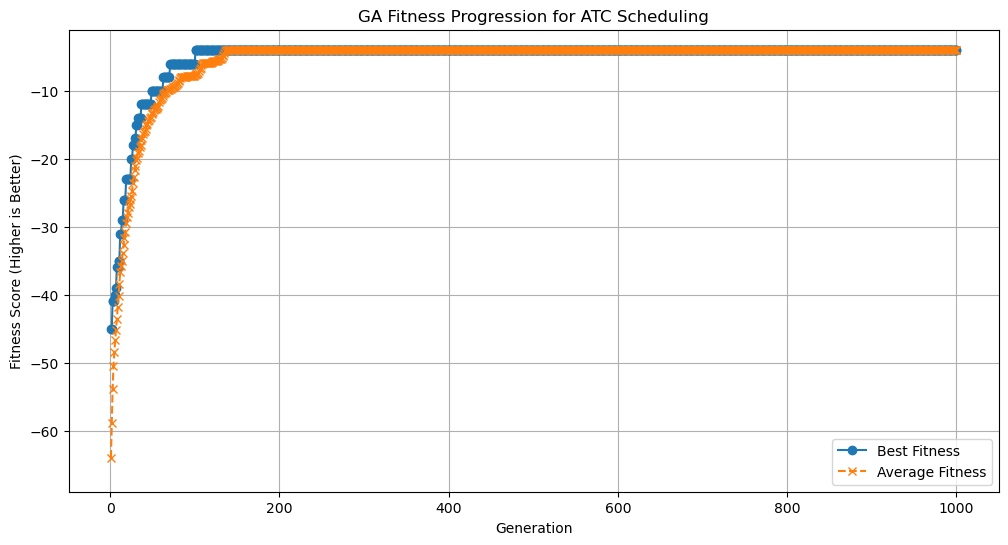

In [183]:
def parent_selection (population, fitness_scores):
    total_fitness = sum(fitness_scores)
    selection_probs = [f / total_fitness for f in fitness_scores]
    selected_parents = random.choices(population, weights=selection_probs, k=10)
    return selected_parents

best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size = POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history, avg_history)

- Step/Method you are replacing: parent selection

- Step/Method you are replacing it with: tournament selection

- Interpret the results of this replacement:
Tournament selection proved to be the best parent selection mechanism tested yet, with the results converging much faster than any other mechanism.


Generation 1: Best Fitness = -43.00
Generation 10: Best Fitness = -31.00
Generation 20: Best Fitness = -21.00
Generation 30: Best Fitness = -18.00
Generation 40: Best Fitness = -14.00
Generation 50: Best Fitness = -6.00
Generation 60: Best Fitness = -4.00
Generation 70: Best Fitness = -4.00
Generation 80: Best Fitness = -4.00
Generation 90: Best Fitness = -4.00
Generation 100: Best Fitness = -4.00
Generation 110: Best Fitness = -4.00
Generation 120: Best Fitness = -4.00
Generation 130: Best Fitness = -4.00
Generation 140: Best Fitness = -4.00
Generation 150: Best Fitness = -4.00
Generation 160: Best Fitness = -4.00
Generation 170: Best Fitness = -4.00
Generation 180: Best Fitness = -4.00
Generation 190: Best Fitness = -4.00
Generation 200: Best Fitness = -4.00
Generation 210: Best Fitness = -4.00
Generation 220: Best Fitness = -4.00
Generation 230: Best Fitness = -4.00
Generation 240: Best Fitness = -4.00
Generation 250: Best Fitness = -4.00
Generation 260: Best Fitness = -4.00
Generat

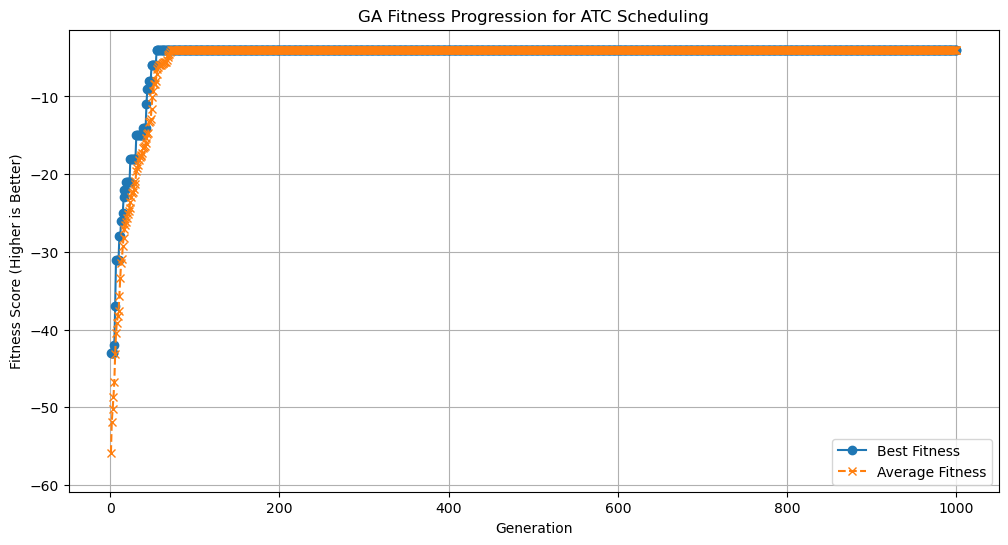

In [185]:
def parent_selection (population, fitness_scores):
    tournament_size = 3
    selected = random.sample(list(zip(population, fitness_scores)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)  # Higher fitness is better
    return selected[0][0], selected[1][0]

best_schedule, best_fitness, history, avg_history = genetic_algorithm(
        population_size = POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history, avg_history)